This notebook shows ways how to calibrate the magnitude of applied static Guassian Noise to VED 1

In [1]:
import numpy as np 

# define some PIT bins
PIT_BIN_EDGES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [2]:
def get_histogram(var, bins=10, density=False, weights=None):
    """
    author: Haynes and Lagerqvist
    
    source https://github.com/thunderhoser/cira_uq4ml/blob/main/regression_multi_model.ipynb
    
    """
    counts, bin_edges = np.histogram(
        var, bins=bins, density=density, weights=weights)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return counts, bin_centers

In [3]:
def get_pit_evalue(nbins, tsamples):

    """
    author: Haynes and Lagerqvist
    
    source https://github.com/thunderhoser/cira_uq4ml/blob/main/regression_multi_model.ipynb
    
    
    """
    evalue = (1. - 1./nbins)/(tsamples * nbins)
    return np.sqrt(evalue)

In [4]:
def get_pit_dvalue(pit_counts):
    
    """
    author: Haynes and Lagerqvist
    
    source https://github.com/thunderhoser/cira_uq4ml/blob/main/regression_multi_model.ipynb
    """
    
    
    dvalue = 0.
    nbins = pit_counts.shape[0]
    nbinsI = 1./nbins

    pitTot = np.sum(pit_counts)
    pit_freq = np.divide(pit_counts, pitTot)
    for i in range(nbins):
        dvalue += (pit_freq[i] - nbinsI) * (pit_freq[i] - nbinsI)
    dvalue = np.sqrt(dvalue/nbins)
    return dvalue

In [5]:
def get_pit_points_ens(ytrue, ypred,
    pit_bins=PIT_BIN_EDGES,normal=True):
    """
    author: Haynes and Lagerqvist
    
    source https://github.com/thunderhoser/cira_uq4ml/blob/main/regression_multi_model.ipynb
    
    
    Program to calculate Probability Integral Transform (PIT)
    points from ensemble predictions.

    Assumes a single target.

    Input:
    ytrue: An array containing the true samples with a single target.
    ypred: An array containing the predictions for a single target,
      with the ensemble members in the last dimension 
      i.e. shape = (..., nEns), nEns = # of ensemble members

    Output:
    Dictionary containing the PIT information.
    """

    nTr = ytrue.size
    nPr = ypred.size
    if nTr == nPr:
        print("Using ensemble version of get_pit_points, ")
        print("   but the predictions are not ensembles.")
        return {}

    nBins = len(pit_bins) - 1
    nEns = ypred.shape[-1]
    nSamples = ytrue.size
    pit_evalue = get_pit_evalue(nBins, nSamples)

    ytrueT = ytrue.reshape(-1)
    ypredT = ypred.reshape((nSamples, nEns))
    ypredTS = np.sort(ypredT, axis=1)

    ytrueTE = np.repeat(
      ytrueT[..., np.newaxis], nEns, axis=-1)
    pred_diff = np.abs(np.subtract(ytrueTE, ypredTS))
    pit_values = np.divide(np.argmin(pred_diff, axis=-1), nEns)
    weights = np.ones_like(pit_values) / nSamples
    if normal==True:
        pit_counts, bin_centers = get_histogram(\
            pit_values, bins=pit_bins, weights=weights)
    if normal==False:
        pit_counts, bin_centers = get_histogram(\
            pit_values, bins=pit_bins)
    

    pDict = {
      'pit_centers': bin_centers,
      'pit_counts': pit_counts,
      'pit_dvalue': get_pit_dvalue(pit_counts),
      'pit_evalue': pit_evalue,
      'pit_values': pit_values,
      'pit_weights': weights}
      
    return pDict

In [6]:
## import some packages 

from tensorflow.keras.layers import Input, Dense, Concatenate
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler

import torch as to

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps
import seaborn as sns

2024-02-01 20:31:48.699472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#load Encoder and Decoder of VED 1 into pytorch

VEnc_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
VDec_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')



In [8]:
# define lat and lon of SPCESM grid
lat=np.arange(-90,90,180/96)
lon=np.arange(-180,180,360/144)
latit_array=np.reshape((lat.T*np.ones((lat.size,lon.size)).T).T,int(lat.size*lon.size))


In [10]:
# define input and output variables of VED

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']


out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over ~ 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the VED

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai


PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];

In [11]:
# load test data set
val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [12]:
def VED_pit_distance_calc_internal_stoch(VDecoder,VEncoder,data_set,time_steps,region,noise_level,network_number,normal_):
    """
    computation of CRPS, R², PIT distance for given magnitude of static Latent space perturbation \alpha
    
    """
    
    import xskillscore as xskill

    pit_dist=np.nan*np.ones((113,1))
    pred=np.nan*np.zeros((int(time_steps*96*144),113))

    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)
    diff_R2_PIT=np.nan*np.ones((113,1))
    R_2_1=np.nan*np.ones((113,1))
    CRPS_1=np.nan*np.ones((113,1))


    cloud_ice_true=np.nan*np.zeros((int(time_steps*region.size),113))
    #cloud_ice_bc_pred_1=np.nan*np.zeros((time_steps,region.size,1))
    #cloud_ice_bc_pred_2=np.nan*np.zeros((time_steps,region.size,2))
    #cloud_ice_bc_pred_3=np.nan*np.zeros((time_steps,region.size,3))
    #cloud_ice_bc_pred_4=np.nan*np.zeros((time_steps,region.size,4))
    #cloud_ice_bc_pred_5=np.nan*np.zeros((time_steps,region.size,5))
    #cloud_ice_bc_pred_6=np.nan*np.zeros((int(time_steps*region.size),113,6))
    cloud_ice_bc_pred_7=np.nan*np.zeros((int(time_steps*region.size),113,7))

    cloud_ice_bc_true=np.nan*np.zeros((time_steps*region.size,113))
    
    cloud_ice_bc_pred=np.nan*np.zeros((region.size,113,7))
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder.z_log_var.weight.size()[0]))

    
    for i in np.arange(time_steps):
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        cloud_ice_bc_true[int(i*region.size):int((i+1)*region.size),:]=to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])[:]).detach().numpy()
        cloud_ice_bc_pred[:,:,0]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,1]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,2]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,3]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,4]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,5]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())[:]
        cloud_ice_bc_pred[:,:,6]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())[:]
        
        #stoch_ens_1=np.random.choice(7,1,replace=False)
        #stoch_ens_2=np.random.choice(7,2,replace=False)
        #stoch_ens_3=np.random.choice(7,3,replace=False)
        #stoch_ens_4=np.random.choice(7,4,replace=False)
        #stoch_ens_5=np.random.choice(7,5,replace=False)
        #stoch_ens_6=np.random.choice(7,6,replace=False)




        #cloud_ice_bc_pred_1[i]=cloud_ice_bc_pred[:,stoch_ens_1]
        #cloud_ice_bc_pred_2[i]=cloud_ice_bc_pred[:,stoch_ens_2]
        #cloud_ice_bc_pred_3[i]=cloud_ice_bc_pred[:,stoch_ens_3]
        #cloud_ice_bc_pred_4[i]=cloud_ice_bc_pred[:,stoch_ens_4]
        #cloud_ice_bc_pred_5[i]=cloud_ice_bc_pred[:,stoch_ens_5]
        #cloud_ice_bc_pred_6[int(i*region.size):int((i+1)*region.size)]=cloud_ice_bc_pred[:,:,stoch_ens_6]
        cloud_ice_bc_pred_7[int(i*region.size):int((i+1)*region.size)]=cloud_ice_bc_pred
        
        
        
        pred[int(i*96*144):int((i+1)*96*144)]=np.mean(cloud_ice_bc_pred_7[int(i*region.size):int((i+1)*region.size),:,:],2)
        
        
        
    R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
    ens_2=xr.DataArray(cloud_ice_bc_pred_7,dims=["space_time","SPCESM_var","member"])
    obs=xr.DataArray(cloud_ice_bc_true,dims=["space_time","SPCESM_var"])
        
    crps_ensemble=xskill.crps_ensemble(obs.T,ens_2,dim=[]).mean("space_time")
    
    


    for k in np.arange(cloud_ice_true[1,:].size):
        a=get_pit_points_ens(cloud_ice_bc_true[:,k],cloud_ice_bc_pred_7[:,k],pit_bins=np.arange(0,1.1,1/7),normal=normal_)
        #print(a['pit_counts'])
        #print(np.sum((a['pit_counts']/cloud_ice_bc_true[:,1].size-(1/7))**2))
        pit_dist[k]=np.sum((a['pit_counts']/cloud_ice_bc_true[:,1].size-(1/7))**2)/7
        #print(pit_dist[k])
        
    diff_R2_PIT=(1-R_2_1)+pit_dist
    del pred,cloud_ice_bc_pred_7
    return np.squeeze(pit_dist),np.squeeze(R_2_1),np.squeeze(diff_R2_PIT),np.squeeze(crps_ensemble)


In [13]:
VEnc_1.z_log_var

RecursiveScriptModule(original_name=Linear)

In [14]:
print(a_05.shape)

(113, 1)


In [15]:
print(R_2_0_5.shape)

(113, 1)


In [16]:
print(R_2_PIT_diff_0_5.shape)

(113, 1)


In [13]:
# \alpha=1
a_1,R_2_1,R_2_PIT_diff_1,CRPS_1=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1
                                                              ,val_gen_III,100,
                                                              np.arange(latit_array.size),1,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [14]:
# \alpha= 0.7

a_0_7,R_2_0_7,R_2_PIT_diff_0_7,CRPS_0_7=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                    val_gen_III,100,np.arange(latit_array.size)
                                                                   ,0.7,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [15]:
# \alpha= 0.2

a_0_2,R_2_0_2,R_2_PIT_diff_0_2,CRPS_0_2=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.2,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [16]:
# \alpha= 0.0

a_0_0,R_2_0_0,R_2_PIT_diff_0_0,CRPS_0_0=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.0,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [17]:
# \alpha= 0.3

a_0_3,R_2_0_3,R_2_PIT_diff_0_3,CRPS_0_3=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.3,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [18]:
# \alpha= 0.4

a_0_4,R_2_0_4,R_2_PIT_diff_0_4,CRPS_0_4=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.4,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [19]:
# \alpha= 0.6

a_0_6,R_2_0_6,R_2_PIT_diff_0_6,CRPS_0_6=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.6,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [20]:
# \alpha= 0.8

a_0_8,R_2_0_8,R_2_PIT_diff_0_8,CRPS_0_8=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                    val_gen_III,100,np.arange(latit_array.size),0.8,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [21]:
# \alpha= 0.9

a_0_9,R_2_0_9,R_2_PIT_diff_0_9,CRPS_0_9=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.9,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [22]:
# \alpha= 0.1

a_0_1,R_2_0_1,R_2_PIT_diff_0_1,CRPS_0_1=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.1,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [23]:
# \alpha= 0.5


a_0_5,R_2_0_5,R_2_PIT_diff_0_5,CRPS_0_5=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,
                                                                   val_gen_III,100,np.arange(latit_array.size),0.5,7,normal_=False)

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)


In [29]:
def pit_fine_scale(min_,max_,step_size):
    """
    fine search within a certain interval based on min, max and step size value
    """
    len_=np.arange(min_,max_,step_size)

    pit_array=np.nan*np.zeros((len_.size,113))
    R_2_array=np.nan*np.zeros((len_.size,113))
    loss_array=np.nan*np.zeros((len_.size,113))
    CRPS_array=np.nan*np.zeros((len_.size,113))

    for i in tqdm(np.arange(len_.size)):
        pit_array[i],R_2_array[i],loss_array[i],CRPS_array[i]=VED_pit_distance_calc_internal_stoch(VDec_1,VEnc_1,val_gen_III,
                                                        100,np.arange(latit_array.size),len_[i],7,normal_=False)
    return pit_array,R_2_array,loss_array,CRPS_array,len_
            
          

In [30]:
pit_fine,R_2_fine,loss_fine,CRPS_fine,length=pit_fine_scale(0.30,0.5,0.01)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
/tmp/ipykernel_531754/2618622307.py:69: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1

In [31]:
length

array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ,
       0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

# Vertical Profile plots

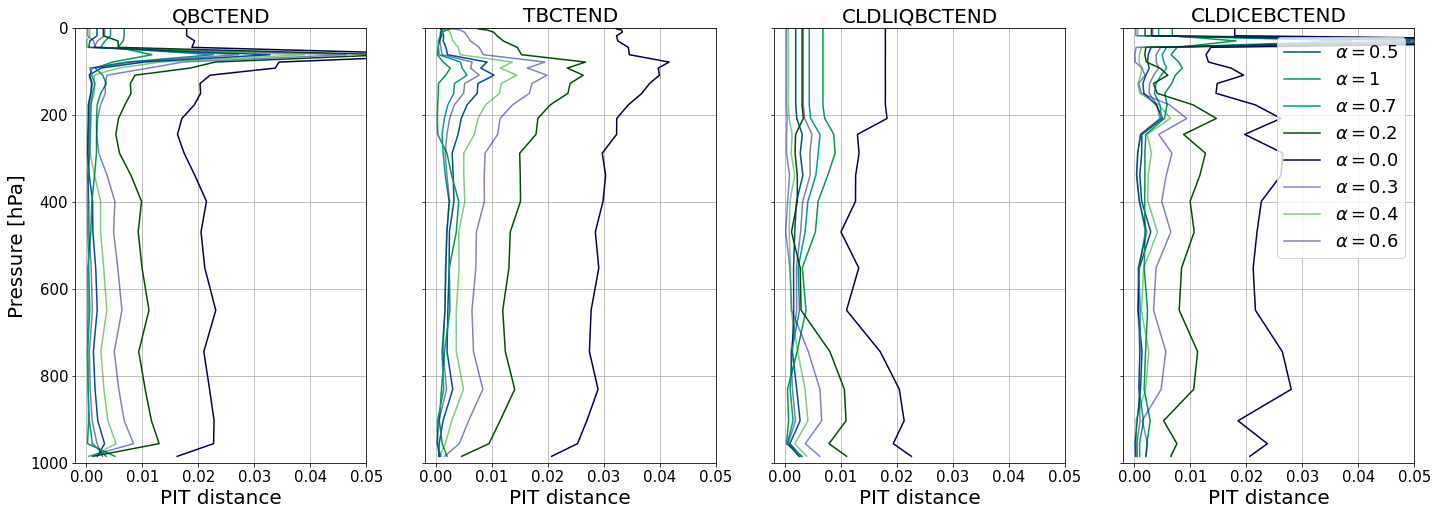

In [25]:
#PIT distances vertical profiles

plt.figure(1,(24,8))
plt.subplot(1,4,1)

plt.plot(a_0_5[0:26],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(a_1[0:26],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(a_0_7[0:26],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(a_0_2[0:26],P[0:26]/100,color=[0,0.3,0])
plt.plot(a_0_0[0:26],P[0:26]/100,color=[0,0,0.3])
plt.plot(a_0_3[0:26],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(a_0_4[0:26],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(a_0_6[0:26],P[0:26]/100,color=[0,0,0.3,0.5])


sr=plt.gca()
plt.xlim(-0.002,0.05)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'PIT distance',fontsize=20)
plt.title('QBCTEND',fontsize=20)


ax_2=plt.subplot(1,4,2)
plt.plot(a_0_5[26:52],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(a_1[26:52],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(a_0_7[26:52],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(a_0_2[26:52],P[0:26]/100,color=[0,0.3,0])
plt.plot(a_0_0[26:52],P[0:26]/100,color=[0,0,0.3])
plt.plot(a_0_3[26:52],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(a_0_4[26:52],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(a_0_6[26:52],P[0:26]/100,color=[0,0,0.3,0.5])


sr=plt.gca()
plt.xlim(-0.002,0.05)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'PIT distance',fontsize=20)
plt.title('TBCTEND',fontsize=20)


ax_3=plt.subplot(1,4,3)



plt.plot(a_0_5[52:78],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(a_1[52:78],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(a_0_7[52:78],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(a_0_2[52:78],P[0:26]/100,color=[0,0.3,0])
plt.plot(a_0_0[52:78],P[0:26]/100,color=[0,0,0.3])
plt.plot(a_0_3[52:78],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(a_0_4[52:78],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(a_0_6[52:78],P[0:26]/100,color=[0,0,0.3,0.5])



sr=plt.gca()
plt.xlim(-0.002,0.05)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_3.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'PIT distance',fontsize=20)
plt.title('CLDLIQBCTEND',fontsize=20)

ax_4=plt.subplot(1,4,4)


plt.plot(a_0_5[78:104],P[0:26]/100,color=[0,0.3,0.6],label=r'$\alpha=0.5$')
plt.plot(a_1[78:104],P[0:26]/100,color=[0,0.6,0.3],label=r'$\alpha=1$')
plt.plot(a_0_7[78:104],P[0:26]/100,color=[0,0.6,0.6],label=r'$\alpha=0.7$')
plt.plot(a_0_2[78:104],P[0:26]/100,color=[0,0.3,0],label=r'$\alpha=0.2$')
plt.plot(a_0_0[78:104],P[0:26]/100,color=[0,0,0.3],label=r'$\alpha=0.0$')
plt.plot(a_0_3[78:104],P[0:26]/100,color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(a_0_4[78:104],P[0:26]/100,color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(a_0_6[78:104],P[0:26]/100,color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')


sr=plt.gca()
plt.xlim(-0.002,0.05)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'PIT distance',fontsize=20)
plt.title('CLDICEBCTEND',fontsize=20)
plt.legend(fontsize=18,loc=1)


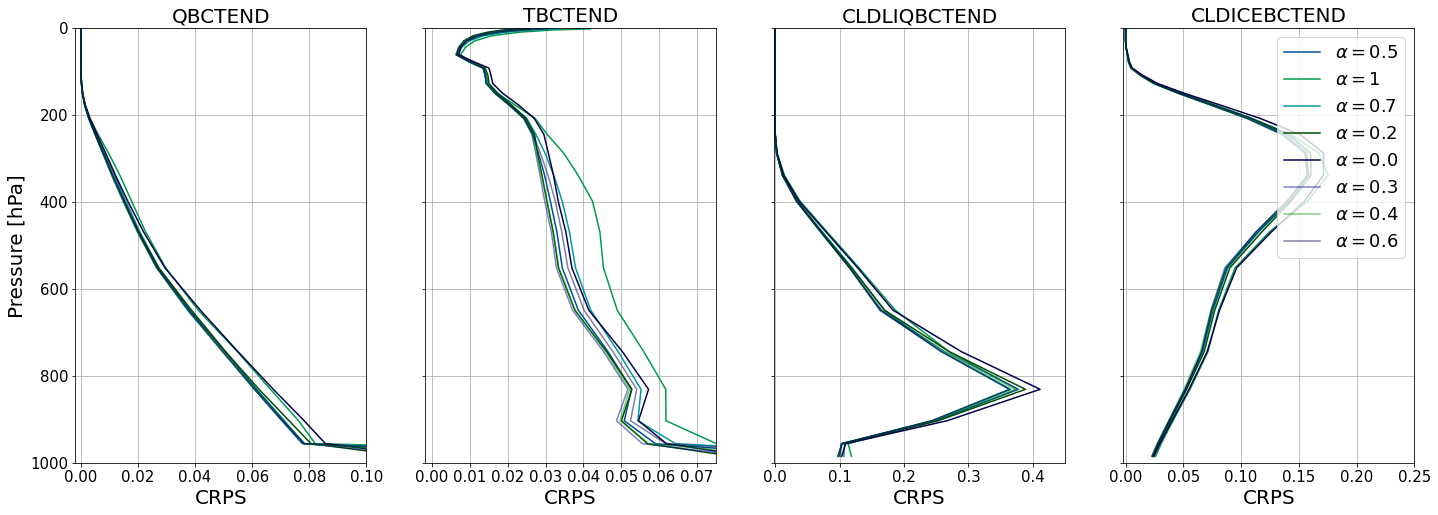

In [26]:
# vertical profiles of CRPS

plt.figure(1,(24,8))
plt.subplot(1,4,1)

plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_5[0:26],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_1[0:26],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_7[0:26],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_2[0:26],P[0:26]/100,color=[0,0.3,0])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_0[0:26],P[0:26]/100,color=[0,0,0.3])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_3[0:26],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_4[0:26],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(val_gen_III.output_transform.scale[0:26]*CRPS_0_6[0:26],P[0:26]/100,color=[0,0,0.3,0.5])



sr=plt.gca()
plt.xlim(-0.002,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'CRPS',fontsize=20)
plt.title('QBCTEND',fontsize=20)


ax_2=plt.subplot(1,4,2)
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_5[26:52],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_1[26:52],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_7[26:52],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_2[26:52],P[0:26]/100,color=[0,0.3,0])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_0[26:52],P[0:26]/100,color=[0,0,0.3])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_3[26:52],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_4[26:52],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(val_gen_III.output_transform.scale[26:52]*CRPS_0_6[26:52],P[0:26]/100,color=[0,0,0.3,0.5])



sr=plt.gca()
plt.xlim(-0.002,0.075)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'CRPS',fontsize=20)
plt.title('TBCTEND',fontsize=20)


ax_3=plt.subplot(1,4,3)



plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_5[52:78],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_1[52:78],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_7[52:78],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_2[52:78],P[0:26]/100,color=[0,0.3,0])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_0[52:78],P[0:26]/100,color=[0,0,0.3])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_3[52:78],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_4[52:78],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(val_gen_III.output_transform.scale[52:78]*CRPS_0_6[52:78],P[0:26]/100,color=[0,0,0.3,0.5])

sr=plt.gca()
plt.xlim(-0.002,0.45)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_3.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'CRPS',fontsize=20)
plt.title('CLDLIQBCTEND',fontsize=20)

ax_4=plt.subplot(1,4,4)


plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_5[78:104],P[0:26]/100,color=[0,0.3,0.6],label=r'$\alpha=0.5$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_1[78:104],P[0:26]/100,color=[0,0.6,0.3],label=r'$\alpha=1$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_7[78:104],P[0:26]/100,color=[0,0.6,0.6],label=r'$\alpha=0.7$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_2[78:104],P[0:26]/100,color=[0,0.3,0],label=r'$\alpha=0.2$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_0[78:104],P[0:26]/100,color=[0,0,0.3],label=r'$\alpha=0.0$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_3[78:104],P[0:26]/100,color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_4[78:104],P[0:26]/100,color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(val_gen_III.output_transform.scale[78:104]*CRPS_0_6[78:104],P[0:26]/100,color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')


sr=plt.gca()
plt.xlim(-0.002,0.25)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'CRPS',fontsize=20)
plt.title('CLDICEBCTEND',fontsize=20)
plt.legend(fontsize=18,loc=1)


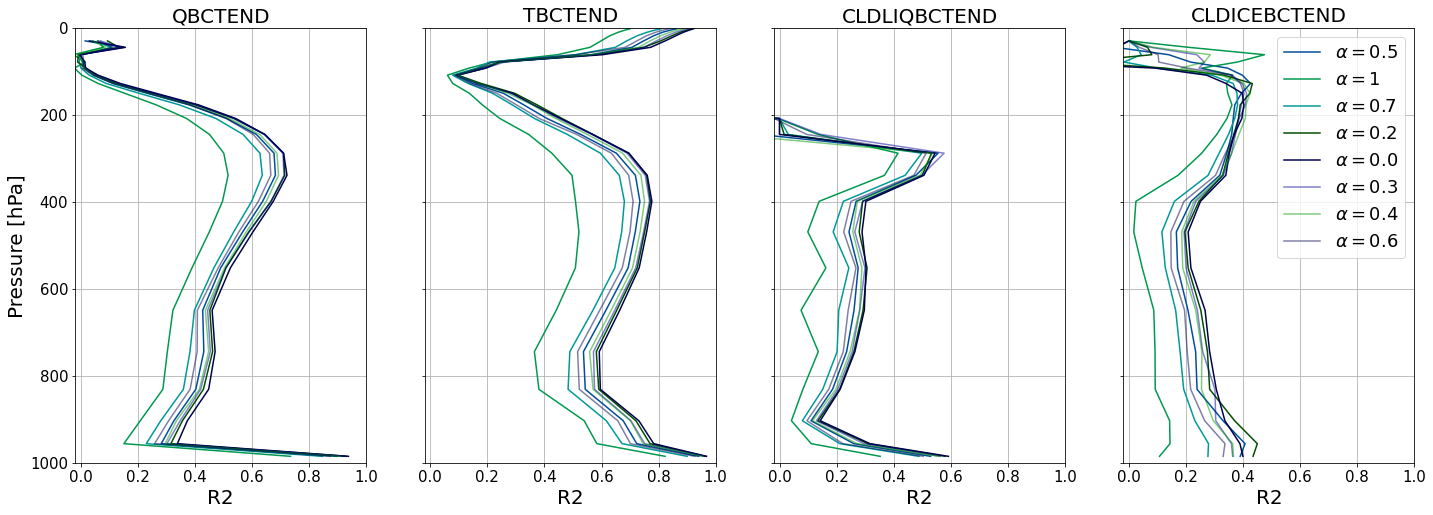

In [27]:
# and R² 

plt.figure(1,(24,8))
plt.subplot(1,4,1)

plt.plot(R_2_0_5[0:26],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_1[0:26],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_0_7[0:26],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_0_2[0:26],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_0_0[0:26],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_0_3[0:26],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_0_4[0:26],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_0_6[0:26],P[0:26]/100,color=[0,0,0.3,0.5])

sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'R2',fontsize=20)
plt.title('QBCTEND',fontsize=20)


ax_2=plt.subplot(1,4,2)
plt.plot(R_2_0_5[26:52],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_1[26:52],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_0_7[26:52],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_0_2[26:52],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_0_0[26:52],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_0_3[26:52],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_0_4[26:52],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_0_6[26:52],P[0:26]/100,color=[0,0,0.3,0.5])

sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'R2',fontsize=20)
plt.title('TBCTEND',fontsize=20)


ax_3=plt.subplot(1,4,3)



plt.plot(R_2_0_5[52:78],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_1[52:78],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_0_7[52:78],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_0_2[52:78],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_0_0[52:78],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_0_3[52:78],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_0_4[52:78],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_0_6[52:78],P[0:26]/100,color=[0,0,0.3,0.5])

sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_3.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'R2',fontsize=20)
plt.title('CLDLIQBCTEND',fontsize=20)

ax_4=plt.subplot(1,4,4)


plt.plot(R_2_0_5[78:104],P[0:26]/100,color=[0,0.3,0.6],label=r'$\alpha=0.5$')
plt.plot(R_2_1[78:104],P[0:26]/100,color=[0,0.6,0.3],label=r'$\alpha=1$')
plt.plot(R_2_0_7[78:104],P[0:26]/100,color=[0,0.6,0.6],label=r'$\alpha=0.7$')
plt.plot(R_2_0_2[78:104],P[0:26]/100,color=[0,0.3,0],label=r'$\alpha=0.2$')
plt.plot(R_2_0_0[78:104],P[0:26]/100,color=[0,0,0.3],label=r'$\alpha=0.0$')
plt.plot(R_2_0_3[78:104],P[0:26]/100,color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(R_2_0_4[78:104],P[0:26]/100,color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(R_2_0_6[78:104],P[0:26]/100,color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'R2',fontsize=20)
plt.title('CLDICEBCTEND',fontsize=20)
plt.legend(fontsize=18,loc=1)


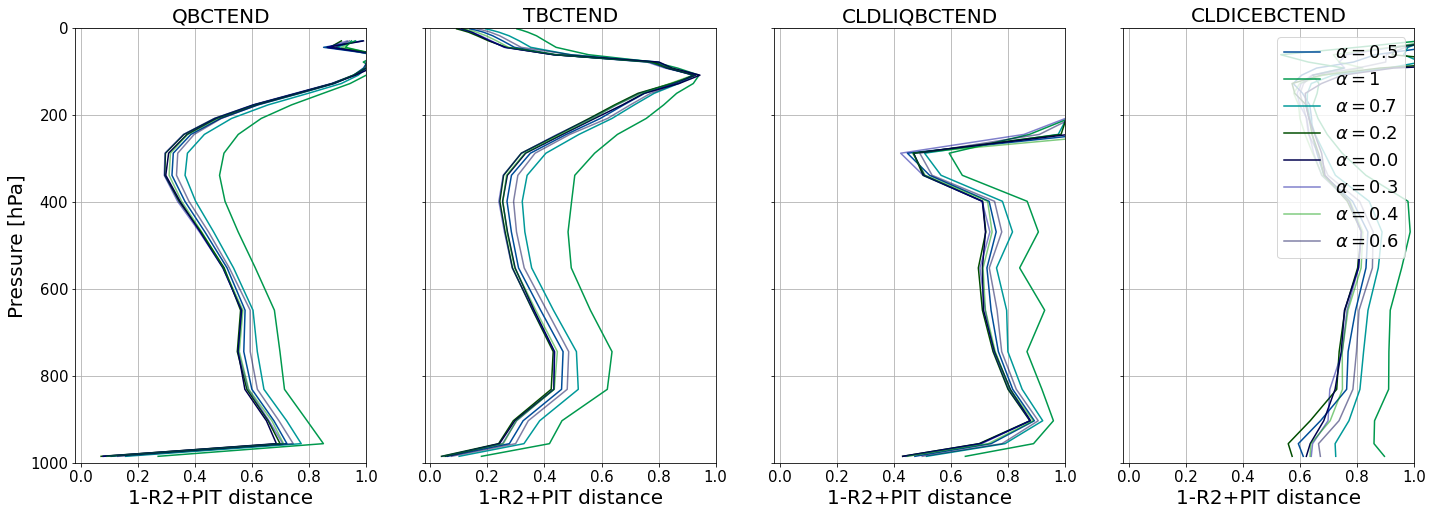

In [28]:
# and the loss function 1 - R² + PIT distance

plt.figure(1,(24,8))
plt.subplot(1,4,1)

plt.plot(R_2_PIT_diff_0_5[0:26],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_PIT_diff_1[0:26],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_PIT_diff_0_7[0:26],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_PIT_diff_0_2[0:26],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_PIT_diff_0_0[0:26],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_PIT_diff_0_3[0:26],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_PIT_diff_0_4[0:26],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_PIT_diff_0_6[0:26],P[0:26]/100,color=[0,0,0.3,0.5])


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'1-R2+PIT distance',fontsize=20)
plt.title('QBCTEND',fontsize=20)


ax_2=plt.subplot(1,4,2)
plt.plot(R_2_PIT_diff_0_5[26:52],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_PIT_diff_1[26:52],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_PIT_diff_0_7[26:52],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_PIT_diff_0_2[26:52],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_PIT_diff_0_0[26:52],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_PIT_diff_0_3[26:52],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_PIT_diff_0_4[26:52],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_PIT_diff_0_6[26:52],P[0:26]/100,color=[0,0,0.3,0.5])


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'1-R2+PIT distance',fontsize=20)
plt.title('TBCTEND',fontsize=20)


ax_3=plt.subplot(1,4,3)



plt.plot(R_2_PIT_diff_0_5[52:78],P[0:26]/100,color=[0,0.3,0.6])
plt.plot(R_2_PIT_diff_1[52:78],P[0:26]/100,color=[0,0.6,0.3])
plt.plot(R_2_PIT_diff_0_7[52:78],P[0:26]/100,color=[0,0.6,0.6])
plt.plot(R_2_PIT_diff_0_2[52:78],P[0:26]/100,color=[0,0.3,0])
plt.plot(R_2_PIT_diff_0_0[52:78],P[0:26]/100,color=[0,0,0.3])
plt.plot(R_2_PIT_diff_0_3[52:78],P[0:26]/100,color=[0,0,0.6,0.5])
plt.plot(R_2_PIT_diff_0_4[52:78],P[0:26]/100,color=[0,0.6,0,0.5])
plt.plot(R_2_PIT_diff_0_6[52:78],P[0:26]/100,color=[0,0,0.3,0.5])

sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_3.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'1-R2+PIT distance',fontsize=20)
plt.title('CLDLIQBCTEND',fontsize=20)

ax_4=plt.subplot(1,4,4)


plt.plot(R_2_PIT_diff_0_5[78:104],P[0:26]/100,color=[0,0.3,0.6],label=r'$\alpha=0.5$')
plt.plot(R_2_PIT_diff_1[78:104],P[0:26]/100,color=[0,0.6,0.3],label=r'$\alpha=1$')
plt.plot(R_2_PIT_diff_0_7[78:104],P[0:26]/100,color=[0,0.6,0.6],label=r'$\alpha=0.7$')
plt.plot(R_2_PIT_diff_0_2[78:104],P[0:26]/100,color=[0,0.3,0],label=r'$\alpha=0.2$')
plt.plot(R_2_PIT_diff_0_0[78:104],P[0:26]/100,color=[0,0,0.3],label=r'$\alpha=0.0$')
plt.plot(R_2_PIT_diff_0_3[78:104],P[0:26]/100,color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(R_2_PIT_diff_0_4[78:104],P[0:26]/100,color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(R_2_PIT_diff_0_6[78:104],P[0:26]/100,color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')


sr=plt.gca()
plt.xlim(-0.02,1)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'1-R2+PIT distance',fontsize=20)
plt.title('CLDICEBCTEND',fontsize=20)
plt.legend(fontsize=18,loc=1)

# Evaluation of 2D Variables 

In [32]:
# define the entire output variable list

output_vars_dict=['QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND',
                  'QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND',
                  'QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND','QBCTEND',
                  'QBCTEND','QBCTEND','TBCTEND','TBCTEND','TBCTEND', 'TBCTEND','TBCTEND','TBCTEND',
                  'TBCTEND','TBCTEND','TBCTEND','TBCTEND','TBCTEND', 'TBCTEND','TBCTEND','TBCTEND',
                  'TBCTEND','TBCTEND','TBCTEND','TBCTEND','TBCTEND', 'TBCTEND','TBCTEND','TBCTEND',
                  'TBCTEND','TBCTEND','TBCTEND','TBCTEND','CLDLIQBCTEND', 'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND',
                  'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND', 'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND',
                  'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND', 'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND',
                  'CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND','CLDLIQBCTEND', 'CLDLIQBCTEND','CLDICEBCTEND','CLDICEBCTEND',
                  'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND', 'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND',
                  'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND', 'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND',
                  'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND', 'CLDICEBCTEND','CLDICEBCTEND','CLDICEBCTEND',
                  'PRECT_CRM_SNOW','PRECT_CRM','NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']
                  
print(len(output_vars_dict))

112


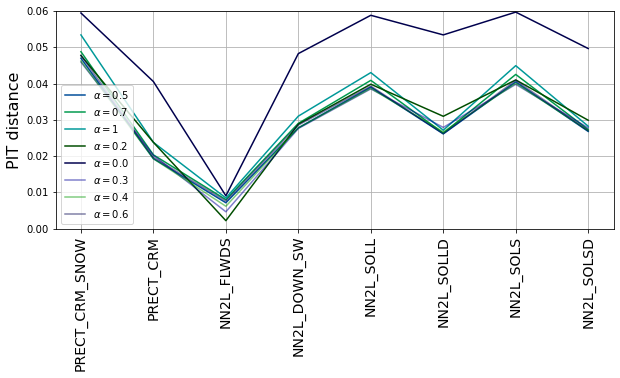

In [33]:
plt.figure(1,(10,4))

plt.plot(a_0_5[105:113],color=[0,0.3,0.6],label=r'$\alpha=0.5$')#$_{median}$')
plt.plot(a_0_7[105:113],color=[0,0.6,0.3],label=r'$\alpha=0.7$')#$_{median}$')
plt.plot(a_1[105:113],color=[0,0.6,0.6],label=r'$\alpha=1$')#$_{median}$')
plt.plot(a_0_2[105:113],color=[0,0.3,0],label=r'$\alpha=0.2$')#$_{median}$')
plt.plot(a_0_0[105:113],color=[0,0,0.3],label=r'$\alpha=0.0$')#$_{median}$')
plt.plot(a_0_3[105:113],color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(a_0_4[105:113],color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(a_0_6[105:113],color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')

plt.xticks(np.arange(a_0_5[105:113].size),output_vars_dict[104:112], rotation='vertical',fontsize=14)
plt.legend()
plt.ylabel(r'PIT distance',fontsize=16)
plt.ylim(0,0.06)
plt.grid(True)

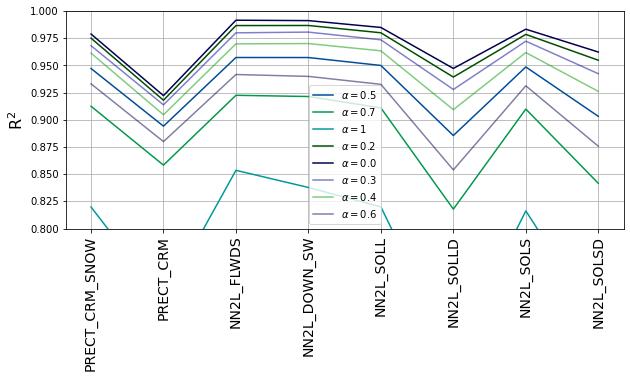

In [34]:
plt.figure(1,(10,4))

plt.plot(R_2_0_5[105:113],color=[0,0.3,0.6],label=r'$\alpha=0.5$')#$_{median}$')
plt.plot(R_2_0_7[105:113],color=[0,0.6,0.3],label=r'$\alpha=0.7$')#$_{median}$')
plt.plot(R_2_1[105:113],color=[0,0.6,0.6],label=r'$\alpha=1$')#$_{median}$')
plt.plot(R_2_0_2[105:113],color=[0,0.3,0],label=r'$\alpha=0.2$')#$_{median}$')
plt.plot(R_2_0_0[105:113],color=[0,0,0.3],label=r'$\alpha=0.0$')#$_{median}$')
plt.plot(R_2_0_3[105:113],color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(R_2_0_4[105:113],color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(R_2_0_6[105:113],color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')

plt.xticks(np.arange(R_2_0_5[105:113].size),output_vars_dict[104:112], rotation='vertical',fontsize=14)
plt.legend()
plt.ylabel(r'R$^2$',fontsize=16)
plt.ylim(0.8,1)
plt.grid(True)

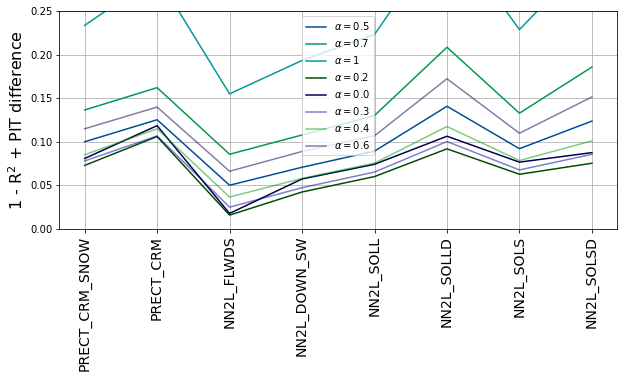

In [35]:
plt.figure(1,(10,4))

plt.plot(R_2_PIT_diff_0_5[105:113],color=[0,0.3,0.6],label=r'$\alpha=0.5$')#$_{median}$')
plt.plot(R_2_PIT_diff_0_7[105:113],color=[0,0.6,0.3],label=r'$\alpha=0.7$')#$_{median}$')
plt.plot(R_2_PIT_diff_1[105:113],color=[0,0.6,0.6],label=r'$\alpha=1$')#$_{median}$')
plt.plot(R_2_PIT_diff_0_2[105:113],color=[0,0.3,0],label=r'$\alpha=0.2$')#$_{median}$')
plt.plot(R_2_PIT_diff_0_0[105:113],color=[0,0,0.3],label=r'$\alpha=0.0$')#$_{median}$')
plt.plot(R_2_PIT_diff_0_3[105:113],color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(R_2_PIT_diff_0_4[105:113],color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(R_2_PIT_diff_0_6[105:113],color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')

plt.xticks(np.arange(R_2_PIT_diff_0_5[105:113].size),output_vars_dict[104:112], rotation='vertical',fontsize=14)
plt.legend()
plt.ylabel(r'1 - R$^2$ + PIT difference',fontsize=16)
plt.ylim(0,0.25)
plt.grid(True)

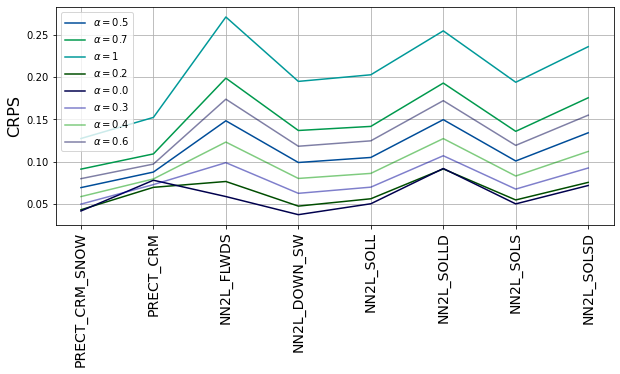

In [36]:
plt.figure(1,(10,4))

plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_5[105:113],color=[0,0.3,0.6],label=r'$\alpha=0.5$')#$_{median}$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_7[105:113],color=[0,0.6,0.3],label=r'$\alpha=0.7$')#$_{median}$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_1[105:113],color=[0,0.6,0.6],label=r'$\alpha=1$')#$_{median}$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_2[105:113],color=[0,0.3,0],label=r'$\alpha=0.2$')#$_{median}$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_0[105:113],color=[0,0,0.3],label=r'$\alpha=0.0$')#$_{median}$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_3[105:113],color=[0,0,0.6,0.5],label=r'$\alpha=0.3$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_4[105:113],color=[0,0.6,0,0.5],label=r'$\alpha=0.4$')
plt.plot(val_gen_III.output_transform.scale[105:113]*CRPS_0_6[105:113],color=[0,0,0.3,0.5],label=r'$\alpha=0.6$')

plt.xticks(np.arange(R_2_0_5[105:113].size),output_vars_dict[104:112], rotation='vertical',fontsize=14)
plt.legend()
plt.ylabel(r'CRPS',fontsize=16)
#plt.ylim(0.8,1)
plt.grid(True)

# Overall plots

In [37]:
alph=np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
means_alpha=np.array([np.mean(a_0_0),np.mean(a_0_1),np.mean(a_0_2),
                      np.mean(a_0_3),np.mean(a_0_4),
                      np.mean(a_0_5),np.mean(a_0_6),
                      np.mean(a_0_7),np.mean(a_0_8),
                      np.mean(a_0_9),np.mean(a_1)])

medians_alpha=np.array([np.median(a_0_0),np.median(a_0_1),np.median(a_0_2),
                      np.median(a_0_3),np.median(a_0_4),
                      np.median(a_0_5),np.median(a_0_6),
                      np.median(a_0_7),np.median(a_0_8),
                      np.median(a_0_9),np.median(a_1)])

perc_75_alpha=np.array([np.percentile(a_0_0,75),np.percentile(a_0_1,75),np.percentile(a_0_2,75),
                      np.percentile(a_0_3,75),np.percentile(a_0_4,75),
                      np.percentile(a_0_5,75),np.percentile(a_0_6,75),
                      np.percentile(a_0_7,75),np.percentile(a_0_8,75),
                      np.percentile(a_0_9,75),np.percentile(a_1,75)])

perc_25_alpha=np.array([np.percentile(a_0_0,25),np.percentile(a_0_1,25),np.percentile(a_0_2,25),
                      np.percentile(a_0_3,25),np.percentile(a_0_4,25),
                      np.percentile(a_0_5,25),np.percentile(a_0_6,25),
                      np.percentile(a_0_7,25),np.percentile(a_0_8,25),
                      np.percentile(a_0_9,25),np.percentile(a_1,25)])


perc_95_alpha=np.array([np.percentile(a_0_0,95),np.percentile(a_0_1,95),np.percentile(a_0_2,95),
                      np.percentile(a_0_3,95),np.percentile(a_0_4,95),
                      np.percentile(a_0_5,95),np.percentile(a_0_6,95),
                      np.percentile(a_0_7,95),np.percentile(a_0_8,95),
                      np.percentile(a_0_9,95),np.percentile(a_1,95)])

perc_5_alpha=np.array([np.percentile(a_0_0,5),np.percentile(a_0_1,5),np.percentile(a_0_2,5),
                      np.percentile(a_0_3,5),np.percentile(a_0_4,5),
                      np.percentile(a_0_5,5),np.percentile(a_0_6,5),
                      np.percentile(a_0_7,5),np.percentile(a_0_8,5),
                      np.percentile(a_0_9,5),np.percentile(a_1,5)])




In [38]:
means_CRPS=np.array([np.mean(CRPS_0_0*val_gen_III.output_transform.scale),np.mean(CRPS_0_1*val_gen_III.output_transform.scale)
                     ,np.mean(CRPS_0_2*val_gen_III.output_transform.scale),
                      np.mean(CRPS_0_3*val_gen_III.output_transform.scale),np.mean(CRPS_0_4*val_gen_III.output_transform.scale),
                      np.mean(CRPS_0_5*val_gen_III.output_transform.scale),np.mean(CRPS_0_6*val_gen_III.output_transform.scale),
                      np.mean(CRPS_0_7*val_gen_III.output_transform.scale),np.mean(CRPS_0_8*val_gen_III.output_transform.scale),
                      np.mean(CRPS_0_9*val_gen_III.output_transform.scale),np.mean(CRPS_1*val_gen_III.output_transform.scale)])

medians_CRPS=np.array([np.median(CRPS_0_0*val_gen_III.output_transform.scale),np.median(CRPS_0_1*val_gen_III.output_transform.scale),
                       np.median(CRPS_0_2*val_gen_III.output_transform.scale),
                      np.median(CRPS_0_3*val_gen_III.output_transform.scale),np.median(CRPS_0_4*val_gen_III.output_transform.scale),
                      np.median(CRPS_0_5*val_gen_III.output_transform.scale),np.median(CRPS_0_6*val_gen_III.output_transform.scale),
                      np.median(CRPS_0_7*val_gen_III.output_transform.scale),np.median(CRPS_0_8*val_gen_III.output_transform.scale),
                      np.median(CRPS_0_9*val_gen_III.output_transform.scale),np.median(CRPS_1*val_gen_III.output_transform.scale)])

perc_75_CRPS=np.array([np.percentile(CRPS_0_0*val_gen_III.output_transform.scale,75),np.percentile(CRPS_0_1*val_gen_III.output_transform.scale,75),
                       np.percentile(CRPS_0_2*val_gen_III.output_transform.scale,75),
                      np.percentile(CRPS_0_3*val_gen_III.output_transform.scale,75),np.percentile(CRPS_0_4*val_gen_III.output_transform.scale,75),
                      np.percentile(CRPS_0_5*val_gen_III.output_transform.scale,75),np.percentile(CRPS_0_6*val_gen_III.output_transform.scale,75),
                      np.percentile(CRPS_0_7*val_gen_III.output_transform.scale,75),np.percentile(CRPS_0_8*val_gen_III.output_transform.scale,75),
                      np.percentile(CRPS_0_9*val_gen_III.output_transform.scale,75),np.percentile(CRPS_1*val_gen_III.output_transform.scale,75)])

perc_25_CRPS=np.array([np.percentile(CRPS_0_0*val_gen_III.output_transform.scale,25),np.percentile(CRPS_0_1*val_gen_III.output_transform.scale,25),
                       np.percentile(CRPS_0_2*val_gen_III.output_transform.scale,25),
                      np.percentile(CRPS_0_3*val_gen_III.output_transform.scale,25),np.percentile(CRPS_0_4*val_gen_III.output_transform.scale,25),
                      np.percentile(CRPS_0_5*val_gen_III.output_transform.scale,25),np.percentile(CRPS_0_6*val_gen_III.output_transform.scale,25),
                      np.percentile(CRPS_0_7*val_gen_III.output_transform.scale,25),np.percentile(CRPS_0_8*val_gen_III.output_transform.scale,25),
                      np.percentile(CRPS_0_9*val_gen_III.output_transform.scale,25),np.percentile(CRPS_1*val_gen_III.output_transform.scale,25)])


perc_95_CRPS=np.array([np.percentile(CRPS_0_0*val_gen_III.output_transform.scale,95),np.percentile(CRPS_0_1*val_gen_III.output_transform.scale,95),
                       np.percentile(CRPS_0_2*val_gen_III.output_transform.scale,95),
                      np.percentile(CRPS_0_3*val_gen_III.output_transform.scale,95),np.percentile(CRPS_0_4*val_gen_III.output_transform.scale,95),
                      np.percentile(CRPS_0_5*val_gen_III.output_transform.scale,95),np.percentile(CRPS_0_6*val_gen_III.output_transform.scale,95),
                      np.percentile(CRPS_0_7*val_gen_III.output_transform.scale,95),np.percentile(CRPS_0_8*val_gen_III.output_transform.scale,95),
                      np.percentile(CRPS_0_9*val_gen_III.output_transform.scale,95),np.percentile(CRPS_1*val_gen_III.output_transform.scale,95)])

perc_5_CRPS=np.array([np.percentile(CRPS_0_0*val_gen_III.output_transform.scale,5),np.percentile(CRPS_0_1*val_gen_III.output_transform.scale,5),
                      np.percentile(CRPS_0_2*val_gen_III.output_transform.scale,5),
                      np.percentile(CRPS_0_3*val_gen_III.output_transform.scale,5),np.percentile(CRPS_0_4*val_gen_III.output_transform.scale,5),
                      np.percentile(CRPS_0_5*val_gen_III.output_transform.scale,5),np.percentile(CRPS_0_6*val_gen_III.output_transform.scale,5),
                      np.percentile(CRPS_0_7*val_gen_III.output_transform.scale,5),np.percentile(CRPS_0_8*val_gen_III.output_transform.scale,5),
                      np.percentile(CRPS_0_9*val_gen_III.output_transform.scale,5),np.percentile(CRPS_1*val_gen_III.output_transform.scale,5)])




In [39]:
means_R_2=np.array([np.mean(R_2_0_0),np.mean(R_2_0_1),np.mean(R_2_0_2),
                      np.mean(R_2_0_3),np.mean(R_2_0_4),
                      np.mean(R_2_0_5),np.mean(R_2_0_6),
                      np.mean(R_2_0_7),np.mean(R_2_0_8),
                      np.mean(R_2_0_9),np.mean(R_2_1)])

medians_R_2=np.array([np.median(R_2_0_0),np.median(R_2_0_1),np.median(R_2_0_2),
                      np.median(R_2_0_3),np.median(R_2_0_4),
                      np.median(R_2_0_5),np.median(R_2_0_6),
                      np.median(R_2_0_7),np.median(R_2_0_8),
                      np.median(R_2_0_9),np.median(R_2_1)])

perc_75_R_2=np.array([np.percentile(R_2_0_0,75),np.percentile(R_2_0_1,75),np.percentile(R_2_0_2,75),
                      np.percentile(R_2_0_3,75),np.percentile(R_2_0_4,75),
                      np.percentile(R_2_0_5,75),np.percentile(R_2_0_6,75),
                      np.percentile(R_2_0_7,75),np.percentile(R_2_0_8,75),
                      np.percentile(R_2_0_9,75),np.percentile(R_2_1,75)])

perc_25_R_2=np.array([np.percentile(R_2_0_0,25),np.percentile(R_2_0_1,25),np.percentile(R_2_0_2,25),
                      np.percentile(R_2_0_3,25),np.percentile(R_2_0_4,25),
                      np.percentile(R_2_0_5,25),np.percentile(R_2_0_6,25),
                      np.percentile(R_2_0_7,25),np.percentile(R_2_0_8,25),
                      np.percentile(R_2_0_9,25),np.percentile(R_2_1,25)])


perc_95_R_2=np.array([np.percentile(R_2_0_0,95),np.percentile(R_2_0_1,95),np.percentile(R_2_0_2,95),
                      np.percentile(R_2_0_3,95),np.percentile(R_2_0_4,95),
                      np.percentile(R_2_0_5,95),np.percentile(R_2_0_6,95),
                      np.percentile(R_2_0_7,95),np.percentile(R_2_0_8,95),
                      np.percentile(R_2_0_9,95),np.percentile(R_2_1,95)])

perc_5_R_2=np.array([np.percentile(R_2_0_0,5),np.percentile(R_2_0_1,5),np.percentile(R_2_0_2,5),
                      np.percentile(R_2_0_3,5),np.percentile(R_2_0_4,5),
                      np.percentile(R_2_0_5,5),np.percentile(R_2_0_6,5),
                      np.percentile(R_2_0_7,5),np.percentile(R_2_0_8,5),
                      np.percentile(R_2_0_9,5),np.percentile(R_2_1,5)])




/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# PIT distance vs. static latent perturbation

Text(0.5, 0, 'Static Latent Perturbation $\\alpha_i$')

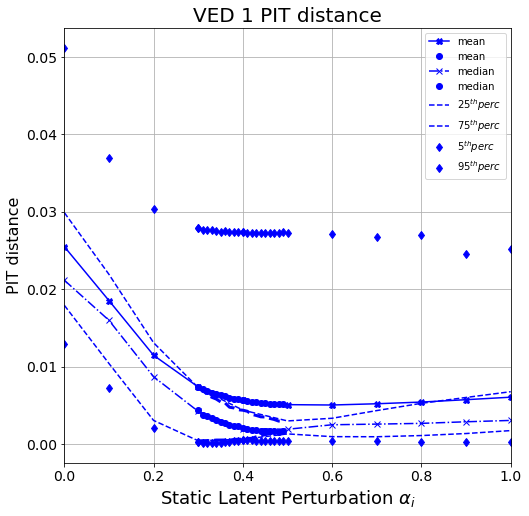

In [40]:
plt.figure(1,(8,8))
plt.plot(alph,means_alpha,'bX-',label='mean')
plt.plot(length,np.mean(pit_fine,1),'bo',label='mean')

plt.plot(alph,medians_alpha,'bx-.',label='median')
plt.plot(length,np.median(pit_fine,1),'bo',label='median')

plt.plot(alph,perc_25_alpha,'b--',label=r'25$^{th} perc$')
plt.plot(length,np.percentile(pit_fine,axis=1,q=25),'b--',linewidth=3)

plt.plot(alph,perc_75_alpha,'b--',label=r'75$^{th} perc$')
plt.plot(length,np.percentile(pit_fine,axis=1,q=75),'b--',linewidth=3)

plt.plot(alph,perc_5_alpha,'bd',label=r'5$^{th} perc$')
plt.plot(length,np.percentile(pit_fine,axis=1,q=5),'bd')

plt.plot(alph,perc_95_alpha,'bd',label=r'95$^{th} perc$')
plt.plot(length,np.percentile(pit_fine,axis=1,q=95),'bd')


plt.legend()
plt.ylabel(r'PIT distance',fontsize=16)
plt.xlim(-0,1)
plt.grid(True)
plt.title(r"VED 1 PIT distance",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Static Latent Perturbation $\alpha_i$',fontsize=18)

In [41]:
# print best values for given percentile for fine search

print(length[np.min(np.median(pit_fine,1))==np.median(pit_fine,1)])
print(length[np.min(np.mean(pit_fine,1))==np.mean(pit_fine,1)])
print(length[np.min(np.percentile(pit_fine,75,1))==np.percentile(pit_fine,75,1)])
print(length[np.min(np.percentile(pit_fine,95,1))==np.percentile(pit_fine,95,1)])
print(length[np.min(np.percentile(pit_fine,25,1))==np.percentile(pit_fine,25,1)])
print(length[np.min(np.percentile(pit_fine,5,1))==np.percentile(pit_fine,5,1)])


[0.48]
[0.49]
[0.49]
[0.45]
[0.3]
[0.33]


In [42]:
# print best values for given percentile for coarse search


print(alph[np.min(medians_alpha)==medians_alpha])
print(alph[np.min(means_alpha)==means_alpha])
print(alph[np.min(perc_75_alpha)==perc_75_alpha])
print(alph[np.min(perc_95_alpha)==perc_95_alpha])
print(alph[np.min(perc_25_alpha)==perc_25_alpha])
print(alph[np.min(perc_5_alpha)==perc_5_alpha])


[0.5]
[0.6]
[0.5]
[0.9]
[0.3]
[0.3]


# CRPS vs. static latent perturbation

Text(0.5, 0, 'Static Latent Perturbation $\\alpha_i$')

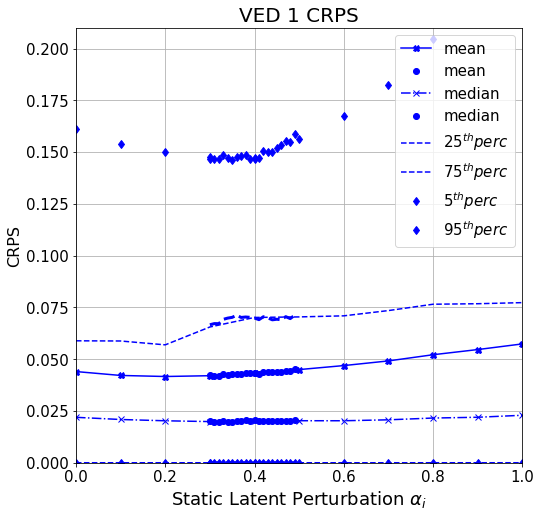

In [43]:
plt.figure(1,(8,8))
plt.plot(alph,means_CRPS,'bX-',label='mean')
plt.plot(length,np.mean(CRPS_fine*val_gen_III.output_transform.scale,1),'bo',label='mean')

plt.plot(alph,medians_CRPS,'bx-.',label='median')
plt.plot(length,np.median(CRPS_fine*val_gen_III.output_transform.scale,1),'bo',label='median')

plt.plot(alph,perc_25_CRPS,'b--',label=r'25$^{th} perc$')
plt.plot(length,np.percentile(CRPS_fine*val_gen_III.output_transform.scale,axis=1,q=25),'b--',linewidth=3)

plt.plot(alph,perc_75_CRPS,'b--',label=r'75$^{th} perc$')
plt.plot(length,np.percentile(CRPS_fine*val_gen_III.output_transform.scale,axis=1,q=75),'b--',linewidth=3)

plt.plot(alph,perc_5_CRPS,'bd',label=r'5$^{th} perc$')
plt.plot(length,np.percentile(CRPS_fine*val_gen_III.output_transform.scale,axis=1,q=5),'bd')

plt.plot(alph,perc_95_CRPS,'bd',label=r'95$^{th} perc$')
plt.plot(length,np.percentile(CRPS_fine*val_gen_III.output_transform.scale,axis=1,q=95),'bd')


plt.legend(fontsize=15)
plt.ylabel(r'CRPS',fontsize=16)
plt.xlim(-0,1)
plt.ylim(0,0.21)
plt.grid(True)
plt.title(r"VED 1 CRPS",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Static Latent Perturbation $\alpha_i$',fontsize=18)

In [44]:
# get best values coarse search 

print(alph[np.min(medians_CRPS)==medians_CRPS])
print(alph[np.min(means_CRPS)==means_CRPS])
print(alph[np.min(perc_75_CRPS)==perc_75_CRPS])
print(alph[np.min(perc_95_CRPS)==perc_95_CRPS])
print(alph[np.min(perc_25_CRPS)==perc_25_CRPS])
print(alph[np.min(perc_5_CRPS)==perc_5_CRPS])


[0.3]
[0.2]
[0.2]
[0.3]
[0.3]
[0.6]


In [45]:
# get best values fine search 


print(length[np.min(np.median(CRPS_fine*val_gen_III.output_transform.scale,1))==np.median(CRPS_fine*val_gen_III.output_transform.scale,1)])
print(length[np.min(np.mean(CRPS_fine*val_gen_III.output_transform.scale,1))==np.mean(CRPS_fine*val_gen_III.output_transform.scale,1)])
print(length[np.min(np.percentile(CRPS_fine*val_gen_III.output_transform.scale,75,1))==np.percentile(CRPS_fine*val_gen_III.output_transform.scale,75,1)])
print(length[np.min(np.percentile(CRPS_fine*val_gen_III.output_transform.scale,95,1))==np.percentile(CRPS_fine*val_gen_III.output_transform.scale,95,1)])
print(length[np.min(np.percentile(CRPS_fine*val_gen_III.output_transform.scale,25,1))==np.percentile(CRPS_fine*val_gen_III.output_transform.scale,25,1)])
print(length[np.min(np.percentile(CRPS_fine*val_gen_III.output_transform.scale,5,1))==np.percentile(CRPS_fine*val_gen_III.output_transform.scale,5,1)])


[0.32]
[0.31]
[0.3]
[0.35]
[0.44]
[0.46]


# R² vs. static latent perturbation

Text(0.5, 0, 'Static Latent Perturbation $\\alpha_i$')

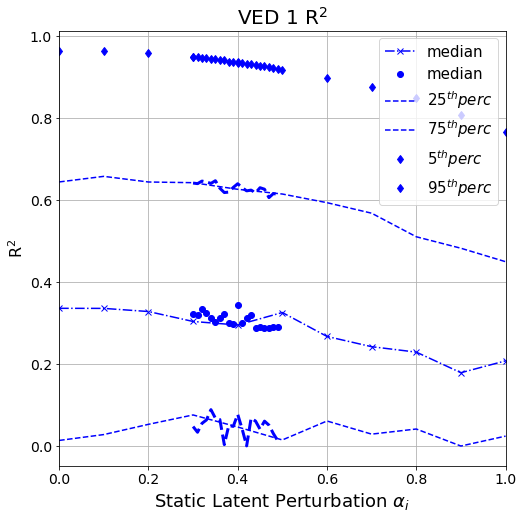

In [46]:
plt.figure(1,(8,8))
#plt.plot(alph,means_R_2,'bX-',label='mean')
#plt.plot(length,np.mean(pit_fine,1),'bo',label='mean')

plt.plot(alph,medians_R_2,'bx-.',label='median')
plt.plot(length,np.median(R_2_fine,1),'bo',label='median')

plt.plot(alph,perc_25_R_2,'b--',label=r'25$^{th} perc$')
plt.plot(length,np.percentile(R_2_fine,axis=1,q=25),'b--',linewidth=3)

plt.plot(alph,perc_75_R_2,'b--',label=r'75$^{th} perc$')
plt.plot(length,np.percentile(R_2_fine,axis=1,q=75),'b--',linewidth=3)

plt.plot(alph,perc_5_R_2,'bd',label=r'5$^{th} perc$')
plt.plot(length,np.percentile(R_2_fine,axis=1,q=5),'bd')

plt.plot(alph,perc_95_R_2,'bd',label=r'95$^{th} perc$')
plt.plot(length,np.percentile(R_2_fine,axis=1,q=95),'bd')


plt.legend(fontsize=15)

plt.ylabel(r'R$^2$',fontsize=16)
plt.xlim(-0,1)
plt.grid(True)
plt.title(r"VED 1 R$^2$",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Static Latent Perturbation $\alpha_i$',fontsize=18)

# combined loss function vs. static latent perturbation

Text(0.5, 0, 'Static Latent Perturbation $\\alpha_i$')

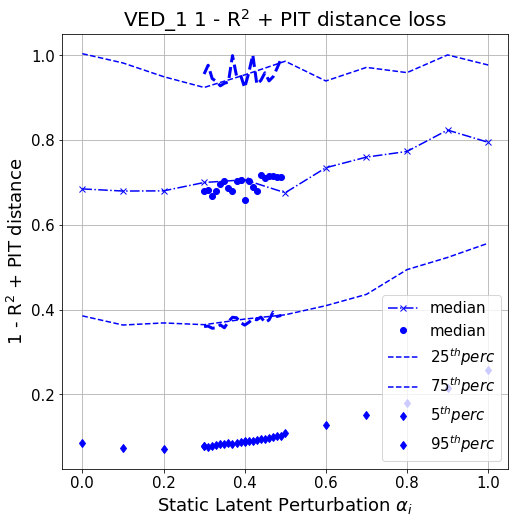

In [47]:
plt.figure(1,(8,8))

plt.plot(alph,(1-medians_R_2)+medians_alpha,'bx-.',label='median')
plt.plot(length,np.nanmedian(loss_fine,1),'bo',label='median')

plt.plot(alph,(1-perc_25_R_2)+perc_25_alpha,'b--',label=r'25$^{th} perc$')
plt.plot(length,np.percentile(loss_fine,axis=1,q=25),'b--',linewidth=3)

plt.plot(alph,(1-perc_75_R_2)+perc_75_alpha,'b--',label=r'75$^{th} perc$')
plt.plot(length,np.percentile(loss_fine,axis=1,q=75),'b--',linewidth=3)

plt.plot(alph,(1-perc_5_R_2)+perc_5_alpha,'bd',label=r'5$^{th} perc$')
plt.plot(length,np.percentile(loss_fine,axis=1,q=5),'bd')

plt.plot(alph,(1-perc_95_R_2)+perc_95_alpha,'bd',label=r'95$^{th} perc$')
plt.plot(length,np.percentile(loss_fine,axis=1,q=95),'bd')
plt.grid(True)
plt.legend(fontsize=15)
plt.title(r"VED_1 1 - R$^2$ + PIT distance loss",fontsize=20)
plt.ylabel(r"1 - R$^2$ + PIT distance",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Static Latent Perturbation $\alpha_i$',fontsize=18)

In [48]:
#get best values for loss function coarse search

print(alph[np.min((1-medians_R_2)+medians_alpha)==(1-medians_R_2)+medians_alpha])
print(alph[np.min((1-perc_25_R_2)+perc_25_alpha)==(1-perc_25_R_2)+perc_25_alpha])
print(alph[np.min((1-perc_75_R_2)+perc_75_alpha)==(1-perc_75_R_2)+perc_75_alpha])
print(alph[np.min((1-perc_95_R_2)+perc_95_alpha)==(1-perc_95_R_2)+perc_95_alpha])
print(alph[np.min((1-perc_5_R_2)+perc_5_alpha)==(1-perc_5_R_2)+perc_5_alpha])


[0.5]
[0.3]
[0.1]
[0.2]
[]


In [49]:
#get best values for loss function fine search

print(length[np.min(np.median(loss_fine,1))==np.median(loss_fine,1)])
#print(length[np.min(np.mean(loss_fine,1))==np.mean(loss_fine,1)])
print(length[np.min(np.percentile(loss_fine,75,1))==np.percentile(loss_fine,75,1)])
print(length[np.min(np.percentile(loss_fine,95,1))==np.percentile(loss_fine,95,1)])
print(length[np.min(np.percentile(loss_fine,25,1))==np.percentile(loss_fine,25,1)])
print(length[np.min(np.percentile(loss_fine,5,1))==np.percentile(loss_fine,5,1)])


[0.4]
[0.4]
[]
[0.32]
[0.31]


In [50]:
length[np.nanmedian(loss_fine,1)==np.min(np.nanmedian(loss_fine,1))]

array([0.4])

In [51]:
length[np.percentile(loss_fine,axis=1,q=25)==np.min(np.percentile(loss_fine,axis=1,q=25))]

array([0.32])

In [52]:
length[np.percentile(loss_fine,axis=1,q=75)==np.min(np.percentile(loss_fine,axis=1,q=75))]

array([0.4])

In [53]:
length[np.percentile(loss_fine,axis=1,q=5)==np.min(np.percentile(loss_fine,axis=1,q=5))]

array([0.31])

In [54]:
length[np.percentile(loss_fine,axis=1,q=95)==np.min(np.percentile(loss_fine,axis=1,q=95))]

array([], dtype=float64)

In [70]:
#%run PIT_sens_VED_1_1.py

(2, 13)
(2, 113)


  0%|          | 0/2 [00:00<?, ?it/s]

/work/bd1083/b309162/CBRAIN-CAM/PIT_sens_VED_1_1.py:301: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
/work/bd1083/b309162/CBRAIN-CAM/PIT_sens_VED_1_1.py:301: RuntimeWarning: divide by zero encountered in true_divide
  R_2_1[:,0]=1-np.nanmean((np.squeeze(cloud_ice_bc_true)-np.squeeze(pred))**2,0)/np.nanvar(np.squeeze(cloud_ice_bc_true),0)
